In [0]:
from google.colab import files
uploaded = files.upload()


Saving speaker1.mp3 to speaker1.mp3
Saving speaker2.mp3 to speaker2.mp3
Saving speaker3.mp3 to speaker3.mp3
Saving speaker4.mp3 to speaker4.mp3
Saving speaker5.mp3 to speaker5.mp3


In [0]:
!pip install pydub
!pip install soundfile

In [0]:
import soundfile as sf
import subprocess
from pydub import silence
from pydub import AudioSegment
from wave import open as open_wave
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import librosa
from librosa import display
import glob
import math
import random
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras import backend as K
from keras import regularizers


In [0]:
!rm -r dataset

In [0]:
audio_length_min = 10
classes = 5
total_length = audio_length_min * 60000
segment_length= 5000
segments = total_length/segment_length
segments = int(segments)
n_mels = 128

In [0]:
#!mkdir wavspeaker
!mkdir dataset
for i in range(0,classes):
  os.mkdir("dataset/s{}".format(i+1))

In [0]:
for i in range(0,classes):
  subprocess.call(['ffmpeg', '-i', './speaker{}.mp3'.format(i+1),
                   './wavspeaker/speaker{}.wav'.format(i+1)])

In [0]:
for i in range(0,classes):
    t1 = 0
    newAudio = AudioSegment.from_wav('./wavspeaker/speaker{}.wav'.format(i+1))
    for j in range(0,segments): 
        newAudio1 = newAudio[t1:(t1+segment_length)]
        newAudio1.export('./dataset/s{}/{}.wav'.format(i+1, j), format="wav")
        t1 = t1 + segment_length

In [0]:
def preprocess_audio_mel(audio, sample_rate=16000, window_size=25,step_size=10, eps=1e-10):
  
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= n_mels)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max))
    return mel_db

In [0]:
def data_make(file_path):
    dataset = glob.glob(file_path)
    data1 = []
    for i in range(0,segments):
        y, sr = librosa.load(dataset[i], sr=16000)
        #y=y.astype(np.float64)
        #y=y/np.abs(np.max(y))
        y = preprocess_audio_mel(audio = y)
        #y=np.reshape(y, (250,320))
        data1.append(y)
    return data1

In [0]:
data1 = data_make('./dataset/s1/*.wav')
data2 = data_make('./dataset/s2/*.wav')
data3 = data_make('./dataset/s3/*.wav')
data4 = data_make('./dataset/s4/*.wav')
data5 = data_make('./dataset/s5/*.wav')

In [0]:
data1 = np.array(data1)
data2 = np.array(data2)
data3 = np.array(data3)
data4 = np.array(data4)
data5 = np.array(data5)

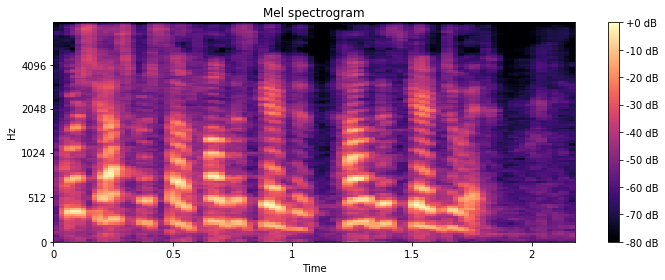

In [0]:
plt.figure(figsize=(10, 4))
display.specshow(data4[1],y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [0]:
odo = AudioSegment.from_wav('./dataset/s1/0.wav')

In [0]:
p = silence.detect_silence(odo, min_silence_len=100)
p

[[0, 3000]]

In [0]:
data1 = np.expand_dims(data1, axis=3)
data2 = np.expand_dims(data2, axis=3)
data3 = np.expand_dims(data3, axis=3)
data4 = np.expand_dims(data4, axis=3)
data5 = np.expand_dims(data5, axis=3)

In [0]:
data1.shape

(60, 300, 300, 1)

In [0]:
data1[0].shape

(128, 94, 1)

In [0]:
def pair_make(item, datacat1, datacat2):
    pair = []
    pair1 = []
    for i in range(item):
        indx = np.random.randint(0, 100)
        indx1 = np.random.randint(0, 100)
        pair.append(datacat1[indx])
        pair1.append(datacat2[indx1])
    return pair, pair1

In [0]:
data = [data1, data2, data3, data4, data5]

In [0]:
classes = 3

In [0]:
pair = []
cor_pair = []
for i in range(0, classes):
  pair1 = []
  pair11 = []
  pair1, pair11 = pair_make(50, data[i],data[i])
  pair = pair + pair1
  cor_pair = cor_pair + pair11

In [0]:
paird = []
diff_paird = []
for i in range(0,classes):
    for j in range(0, classes):
        pair1 = []
        pair11 = []
        if(j<i):
            pair1, pair11 = pair_make(50, data[i],data[j])
            paird = paird + pair1
            diff_paird = diff_paird + pair11

In [0]:
len(pair)

150

In [0]:
len(paird)

150

In [0]:
label1 = [1]*150
label0 = [0]*150

In [0]:
lside = pair + paird
rside = cor_pair + diff_paird
labels = label1 + label0

In [0]:
len(rside)

300

In [0]:
labels = np.array(labels)

In [0]:
X_l = np.array(lside)
X_r = np.array(rside)

In [0]:
X_r.shape

(300, 128, 94, 1)

In [0]:
def get_siamese_model(input_shape):
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    BATCH_NORM = 1
    model.add(Conv2D(8, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', input_shape=(128,94,1), name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(8, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block2_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block2_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block5_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(2048))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2048, name='fc2'))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [0]:
model = get_siamese_model((128,94,1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 128, 94, 1)   0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 128, 94, 1)   0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 2048)         30173528    input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 2048)         0           sequential_8[1][0]               
          

In [0]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
# Train the discriminator
d_loss = model.fit([X_l, X_r],labels,validation_split=0.33,nb_epoch=3000,verbose=1,shuffle=True)

print( d_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 200 samples, validate on 100 samples
Epoch 1/3000
200/200 [==============================] - 24s 122ms/step - loss: 18.2190 - acc: 0.6000 - val_loss: 18.8661 - val_acc: 0.1000
Epoch 2/3000
200/200 [==============================] - 1s 5ms/step - loss: 18.0041 - acc: 0.7750 - val_loss: 18.9795 - val_acc: 0.0800
Epoch 3/3000
200/200 [==============================] - 1s 5ms/step - loss: 17.8743 - acc: 0.8300 - val_loss: 19.1528 - val_acc: 0.0300
Epoch 4/3000
200/200 [==============================] - 1s 5ms/step - loss: 17.7820 - acc: 0.8850 - val_loss: 19.2091 - val_acc: 0.0600
Epoch 5/3000
200/200 [==============================] - 1s 6ms/step - loss: 17.7363 - acc: 0.9150 - val_loss: 19.3111 - val_acc: 0.0900
Epoch 6/3000
200/200 [==============================] - 1s 5ms/step - loss: 17.6577 - acc: 0.9600 - val_loss: 19.3488 - val_acc: 0.0600
Epoch 7/3000
200/200 [==============================] - 1s 6ms/step - loss: 17.6186 - acc: 0.9800 - val_loss: 19.3478 - val_acc: 0.0600

KeyboardInterrupt: ignored

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


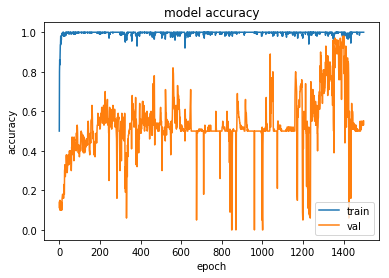

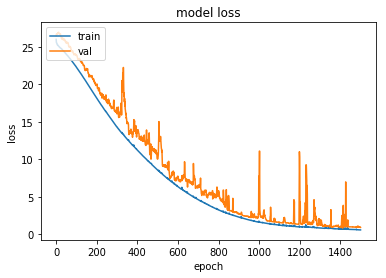

In [0]:
print(d_loss.history.keys())
# summarize history for accuracy
plt.plot(d_loss.history['acc'])
plt.plot(d_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(d_loss.history['loss'])
plt.plot(d_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [0]:
for i in range(1,7):
    j=1
    while(j<i):
      print(j,end =" ")
      j+=1
    print('\n')
    



1 

1 2 

1 2 3 

1 2 3 4 

1 2 3 4 5 



In [0]:
print("-")

-


In [0]:
p=[1.0,2.0,3.0]*2

In [0]:
300000

60000.0

In [0]:
80000

80000